In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import tensorflow as tf
from tensorflow import keras
import numpy as np

def sparse_eye(M):
  #Generates an M x M matrix to be used as sparse identity matrix for the 
  #re-scaling of the sparse recurrent kernel in presence of non-zero leakage.
  #All the non-zero elements are set to 1
  dense_shape = (M,M)
  
  #gives the shape of a ring matrix:
  indices = np.zeros((M,2))
  for i in range(M):
      indices[i,:] = [i,i]
  values = np.ones(shape = (M,)).astype('f')

  W = (tf.sparse.reorder(tf.SparseTensor(indices = indices, values = values, dense_shape = dense_shape)))
  return W

def sparse_tensor(M,N, C = 1):
  #Generates an M x N matrix to be used as sparse (input) kernel
  #For each row only C elements are non-zero
  #(i.e., each input dimension is projected only to C neurons).
  #The non-zero elements are generated randomly from a uniform distribution in [-1,1]
  
  dense_shape = (M,N) #the shape of the dense version of the matrix
  
  indices = np.zeros((M * C,2)) #indices of non-zero elements initialization
  k = 0
  for i in range(M):
    #the indices of non-zero elements in the i-th row of the matrix
    idx =np.random.choice(N,size = C,replace = False)
    for j in range(C):
      indices[k,:] = [i,idx[j]]
      k = k + 1
  values = 2*(2*np.random.rand(M*C).astype('f')-1)
  W = (tf.sparse.reorder(tf.SparseTensor(indices = indices, values = values, dense_shape = dense_shape)))
  return W


def sparse_recurrent_tensor(M, C = 1):
  #Generates an M x M matrix to be used as sparse recurrent kernel
  #For each column only C elements are non-zero
  #(i.e., each recurrent neuron take sinput from C other recurrent neurons).
  #The non-zero elements are generated randomly from a uniform distribution in [-1,1]
  
  dense_shape = (M,M) #the shape of the dense version of the matrix
  
  indices = np.zeros((M * C,2)) #indices of non-zero elements initialization
  k = 0
  for i in range(M):
    #the indices of non-zero elements in the i-th column of the matrix
    idx =np.random.choice(M,size = C,replace = False)
    for j in range(C):
      indices[k,:] = [idx[j],i]
      k = k + 1
  values = 2*(2*np.random.rand(M*C).astype('f')-1)
  W = (tf.sparse.reorder(tf.SparseTensor(indices = indices, values = values, dense_shape = dense_shape)))
  return W


class ReservoirCell(keras.layers.Layer):
    #Implementation of a shallow reservoir to be used as cell of a Recurrent Neural Network
    #The implementation is parametrized by:
    # units - the number of recurrent neurons in the reservoir
    # input_scaling - the max abs value of a weight in the input-reservoir connections
    #                 note that whis value also scales the unitary input bias 
    # spectral_radius - the max abs eigenvalue of the recurrent weight matrix
    # leaky - the leaking rate constant of the reservoir
    # connectivity_input - number of outgoing connections from each input unit to the reservoir
    # connectivity_recurrent - number of incoming recurrent connections for each reservoir unit
    
    def __init__(self, units, 
                 input_scaling = 1., spectral_radius =0.99, leaky = 1, 
                 connectivity_input = 10, connectivity_recurrent = 10,
                 **kwargs):
        
        self.units = units
        self.state_size = units
        self.input_scaling = input_scaling
        self.spectral_radius = spectral_radius
        self.leaky = leaky
        self.connectivity_input = connectivity_input
        self.connectivity_recurrent = connectivity_recurrent
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        
        #build the input weight matrix
        self.kernel = sparse_tensor(input_shape[-1], self.units, self.connectivity_input) * self.input_scaling
        
        
        #build the recurrent weight matrix
        W = sparse_recurrent_tensor(self.units, C = self.connectivity_recurrent)

        #re-scale the weight matrix to control the effective spectral radius of the linearized system
        if (self.leaky ==1):
            #if no leakage then rescale the W matrix
            # compute the spectral radius of the randomly initialized matrix
            e,_ = tf.linalg.eig(tf.sparse.to_dense(W))
            rho = max(abs(e))
            #rescale the matrix to the desired spectral radius
            W = W * (self.spectral_radius / rho)
            self.recurrent_kernel = W
        else:
            I = sparse_eye(self.units)
            W2 = tf.sparse.add(I * (1-self.leaky), W * self.leaky)
            e,_ = tf.linalg.eig(tf.sparse.to_dense(W2))
            rho = max(abs(e))
            W2 = W2 * (self.spectral_radius / rho)
            self.recurrent_kernel =  tf.sparse.add(W2, I * (self.leaky - 1)) * (1/self.leaky)               
        
        self.bias = tf.random.uniform(shape = (self.units,), minval = -1, maxval = 1) * self.input_scaling
        
        self.built = True


    def call(self, inputs, states):
        #computes the output of the cell givne the input and previous state
        prev_output = states[0]

        input_part = tf.sparse.sparse_dense_matmul(inputs, self.kernel)
        state_part = tf.sparse.sparse_dense_matmul(prev_output, self.recurrent_kernel)
        output = prev_output * (1-self.leaky) + tf.nn.tanh(input_part+ self.bias+ state_part) * self.leaky
        
        return output, [output]
    
    
class SimpleDeepReservoirLayer(keras.layers.Layer):
    #A layer structure implementing the functionalities of a Deep Reservoir.
    #The implementation realizes a number of stacked RNN layers using 
    #the ReservoirCell above as core cell.
    #In this simple implementation, all the reservoir levels share the same values
    #of all the hyper-parameters (i.e., the same number of recurrent neurons, spectral radius, etc. )
    #The layer is parametrized by the following:
    # concat - if True the returned state is given by the cocnatenation of all the states in the reservoir levels 
    # units - the number of recurrent units used in the neural network; 
    #         if concat == True this is the total number of units
    #         if concat == False this is the number of units for each reservoir level
    # input_scaling - the scaling coefficient of the first reserovir level
    # inter_scaling - the scaling coefficient of all the other reservoir levels (> 1)
    # spectral_radius - the spectral radius of all the reservoir levels
    # leaky - the leakage coefficient of all the reservoir levels
    # connectivity_input - input connectivity coefficient of the input weight matrix
    # connectivity_inter - input connectivity coefficient of all the inter-levels weight matrices
    # connectivity_recurrent - recurrent connectivity coefficient of all the recurrent weight matrices
    # return_sequences - if True, the state is returned for each time step, otherwise only for the last time step
    
    def __init__(self, units = 100, layers = 1, concat = False,
                 input_scaling = 1, inter_scaling = 1,
                 spectral_radius = 0.99, leaky = 1,
                 connectivity_recurrent = 10, 
                 connectivity_input = 10, 
                 connectivity_inter = 10,
                 return_sequences = False,
                 **kwargs):
        
        super().__init__(**kwargs)
        self.layers = layers
        self.units = units
        

        #in case in which all the reservoir layers are concatenated
        #each level contains units/layers neurons
        #this is done to keep the number of state variables projected to the next layer fixed
        #i.e., the number of trainable parameters does not depend on concat
        if concat:
            units = np.int(units/layers)
        
        
        input_scaling_others = inter_scaling #input scaling for the higher layers
        connectivity_input_1 = connectivity_input  #input connectivity coefficient for the 1st layer
        connectivity_input_others = connectivity_inter #inter-layer connectivity coefficient

        
        #creates a list of reservoirs
        #the first: 
        
        self.reservoir = [
        keras.layers.RNN(ReservoirCell(units = units,
                             input_scaling = input_scaling,
                             spectral_radius = spectral_radius,
                             leaky = leaky,
                             connectivity_input = connectivity_input_1,
                             connectivity_recurrent = connectivity_recurrent),
                             return_sequences=True,return_state=True
                             )]
        #all the others:
        for _ in range(layers-1):
            self.reservoir.append(keras.layers.RNN(ReservoirCell(units = units,
                                                             input_scaling = input_scaling_others,
                                                             spectral_radius = spectral_radius,
                                                             leaky = leaky,
                                                             connectivity_input = connectivity_input_others,
                                                             connectivity_recurrent = connectivity_recurrent),
                                                   return_sequences = True,return_state = True))

        
        self.concat = concat
        
        self.return_sequences = return_sequences
        
        
    def call(self,inputs):
        #compute the output of the deep reservoir
        
        #I = keras.layers.InputLayer(input_shape = self.batch_input_shape)
        
        X = inputs #I(inputs) #external input
        states = [] #list of all the states in all the layers 
        states_last = [] #list of the states in all the layers for the last time step
        layer_states = None
            
        for reservoir_index in range(len(self.reservoir)):
            reservoir_layer = self.reservoir[reservoir_index]
            if reservoir_index > 0:
                X = layer_states
            [layer_states, layer_states_last] = reservoir_layer(X)
            states.append(layer_states)
            states_last.append(layer_states_last)
        
        #concatenate the states if needed
        if self.concat:
            if self.return_sequences:
                #in this case return the concatenation of the states in all the layers
                #at each time step
                return keras.layers.Concatenate()(states)
            else:
                #in this case concatenate the states of all the states in all the layers
                #for the last time step
                return keras.layers.Concatenate()(states_last)            
        else:
            #in this case only the last reservoir layer is used to feed the next layer in the net
            if self.return_sequences:
                #all the time steps for the last layer
                return states[-1]
            else:
                #the last time step for the last layer
                return states_last[-1]    



#The SimpleDeepReservoirLayer can be used to build more complex models.
#As an example, in the following code we create a SimpleDeepESNClassifier 
#that can be trained to classify arbitrarily long input time-series.
#The architecture contains a SimpleDeepReservoirLayer followed by a Dense layer for classification

class SimpleDeepESNClassifier(keras.Model):
    def __init__(self, num_classes, units = 100, layers = 5, 
                 concat = True,
                 spectral_radius = 0.99, leaky = 1,
                 input_scaling = 1, inter_scaling = 1,
                 connectivity_recurrent = 10, 
                 connectivity_input = 10, 
                 connectivity_inter = 10,
                 return_sequences = False,
                 **kwargs):
        super().__init__(**kwargs)
        

        
        self.num_classes = num_classes
        #a Masking layer is used before the SimpleDeepReservoirLayer to deal with
        #possibly arbitrarily long input time-series
        self.masking = tf.keras.layers.Masking()
        self.hidden = SimpleDeepReservoirLayer(units = units, layers = layers,
                                         concat = concat,
                                         spectral_radius = spectral_radius, leaky = leaky,
                                         input_scaling = input_scaling, 
                                         inter_scaling = inter_scaling,
                                         connectivity_recurrent = connectivity_recurrent, 
                                         connectivity_input = connectivity_input, 
                                         connectivity_inter = connectivity_inter,
                                         return_sequences = return_sequences)
        if (num_classes>2):
            self.output_ = tf.keras.layers.Dense(num_classes,
                                                activation = 'softmax')
        else:
            self.output_ = tf.keras.layers.Dense(1,
                                                activation = 'sigmoid')
            
    
    def call(self, inputs):
        m = self.masking(inputs)
        h = self.hidden(m)
        y = self.output_(h)
        return y
    
    

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/BTC-USD.csv')

data = data.drop(labels=range(364, 366), axis=0)

y = data['Close'].values
data=data.drop(columns = ['Close', 'Date'])
X = data.values

In [3]:

y=y.reshape(-1, 1)


import numpy as np
X=np.concatenate((X[1:], y[0:-1]), axis=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y[1:], test_size=0.2, shuffle=False, random_state=42)


In [4]:
x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))

In [ ]:
x_train1.shape

(290, 6, 1)

In [5]:
# univariate bidirectional lstm example
from numpy import array
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D,Flatten, Attention, Dropout, Add, concatenate
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
from keras.regularizers import L1L2

In [17]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, GRU
from keras.layers import Dense, Dropout
from keras.layers import Bidirectional
import tensorflow as tf
# define model
inputs = tensorflow.keras.Input((6, 1))

x = SimpleDeepReservoirLayer(leaky=0.5)(inputs)
outputs = Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 simple_deep_reservoir_layer  (None, 100)              0         
 _5 (SimpleDeepReservoirLaye                                     
 r)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [23]:

model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["mean_absolute_error"],
)

In [25]:
callbacks = [keras.callbacks.EarlyStopping(patience=600, restore_best_weights=True)]

history=model.fit(
    x_train1,
    y_train1,
    validation_data=(x_test1, y_test1),
    epochs=5000,
    batch_size=128,
    callbacks=callbacks,
)


Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 19ms/step - loss: 13972.8691 - mean_absolute_error: 13972.8691 - val_loss: 7205.6670 - val_mean_absolute_error: 7205.6670
Epoch 1214/5000
3/3 [==============================] - 0s 16ms/step - loss: 13963.8252 - mean_absolute_error: 13963.8252 - val_loss: 7196.1616 - val_mean_absolute_error: 7196.1616
Epoch 1215/5000
3/3 [==============================] - 0s 21ms/step - loss: 13954.8115 - mean_absolute_error: 13954.8115 - val_loss: 7186.6582 - val_mean_absolute_error: 7186.6582
Epoch 1216/5000
3/3 [==============================] - 0s 19ms/step - loss: 13945.8115 - mean_absolute_error: 13945.8115 - val_loss: 7177.0713 - val_mean_absolute_error: 7177.0713
Epoch 1217/5000
3/3 [==============================] - 0s 16ms/step - loss: 13936.8184 - mean_absolute_error: 13936.8184 - val_loss: 7167.4355 - val_mean_absolute_error: 7167.4355
Epoch 1218/5000
3/3 [==============================] - 0s 17ms/st

In [26]:
#testing prediction

#testing prediction
ypred=model.predict(x_test1)
#testing prediction

#testing prediction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance
print('mse: ', mean_squared_error(ypred, y_test1))
print('mae: ', mean_absolute_error(ypred, y_test1))
print('r2_score: ', r2_score(ypred, y_test1))
print('explained_variance_score: ', explained_variance_score(ypred, y_test1))
print('max_error: ', max_error(ypred, y_test1))
#print('mean_squared_log_error: ', mean_squared_log_error(ypred, y_test1))
print('mean_poisson_deviance: ', r2_score(ypred, y_test1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(ypred, y_test1))


mse:  919390.7553771363
mae:  721.7733839794523
r2_score:  0.8911166710853806
explained_variance_score:  0.9077934168679399
max_error:  2637.847656500002
mean_poisson_deviance:  0.8911166710853806


In [ ]:
ypred

In [28]:
#training prediction
xpred=model.predict(x_train1)
print('mse: ', mean_squared_error(xpred, y_train1))
print('mae: ', mean_absolute_error(xpred, y_train1))
print('r2_score: ', r2_score(xpred, y_train1))
print('explained_variance_score: ', explained_variance_score(xpred, y_train1))
print('max_error: ', max_error(xpred, y_train1))
#print('mean_squared_log_error: ', mean_squared_log_error(xpred, y_train1))
print('mean_poisson_deviance: ', r2_score(xpred, y_train1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(xpred, y_train1))

mse:  51294521.34123872
mae:  4130.364062530172
r2_score:  -1.2889799121399972
explained_variance_score:  -0.805124535466285
max_error:  22883.01171875
mean_poisson_deviance:  -1.2889799121399972


In [29]:
final_pred = []
real=[]
for i in range(len(xpred)):
    final_pred.append(xpred[i][0])
    real.append(y_train1[i][0])

for i in range(len(ypred)):
    final_pred.append(ypred[i][0])
    real.append(y_test1[i][0])

In [30]:
xx=[]
for i in range(len(final_pred)):
    xx.append(i)

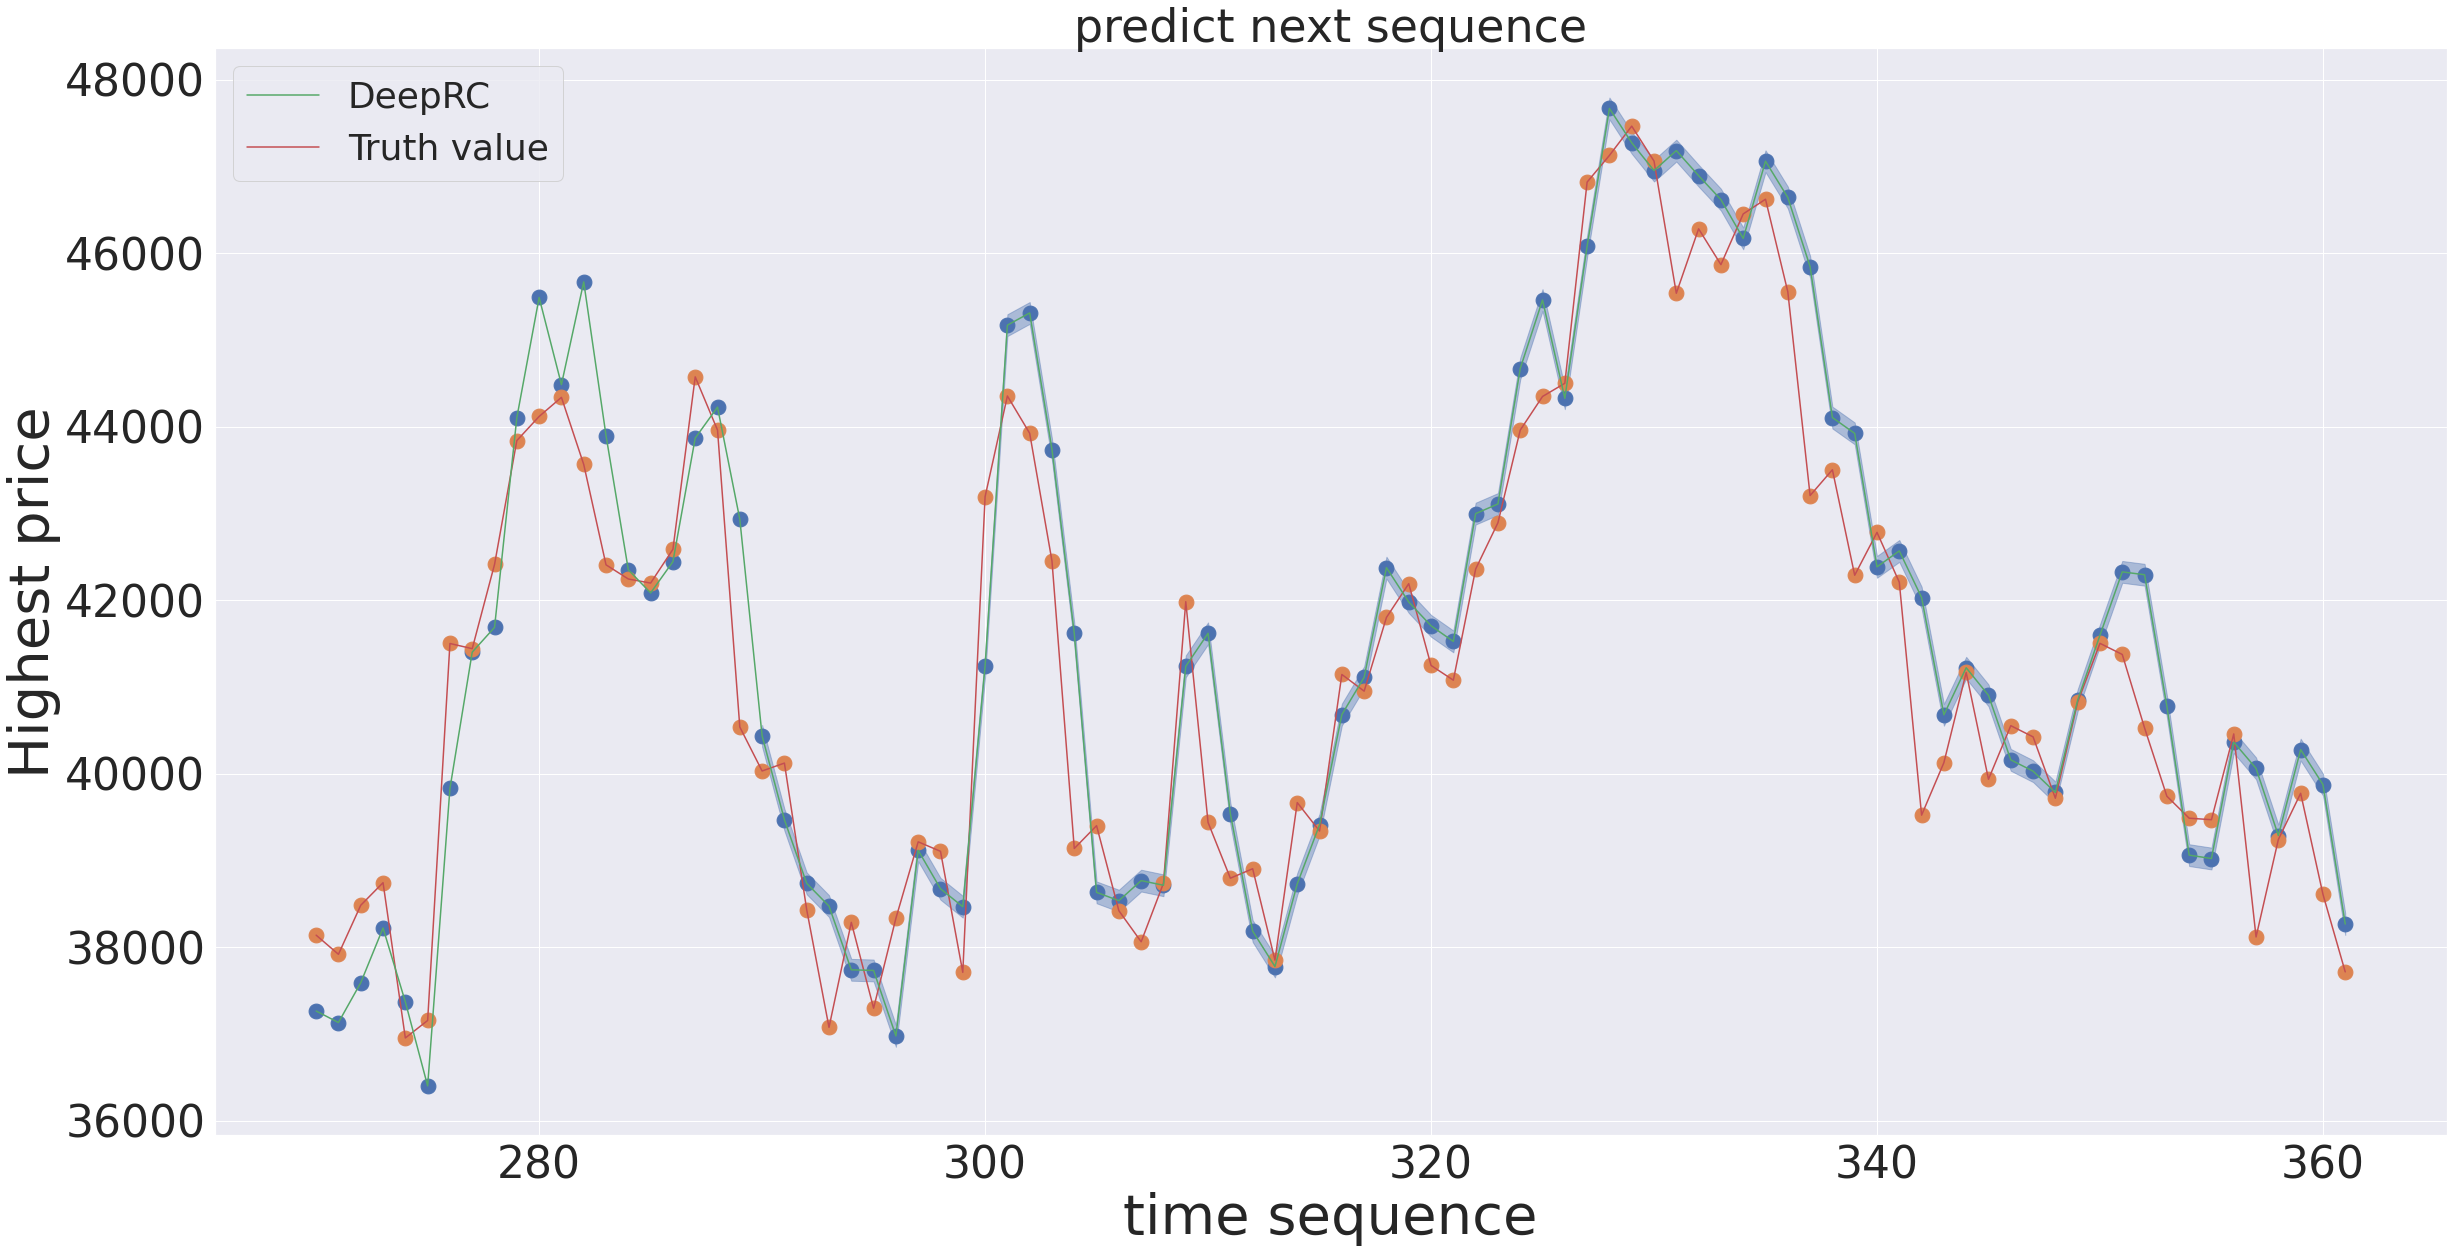

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=270
j=362
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],final_pred[i:j], color='g', label='DeepRC', zorder=10)
plt.plot(xx[i:j],real[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],final_pred[i:j],  s=220, zorder=2)
plt.scatter(xx[i:j],real[i:j],  s=220, zorder=2)
ci = 1200.960 * np.std(final_pred)/np.mean(final_pred)
plt.fill_between(xx[362-72:j], final_pred[362-72:j]-ci, final_pred[362-72:j]+ci, color='b', alpha=.4)

#ax.fill_between(xx[i:j], ypred[i:j], ypred[i:j], color='b', alpha=.1)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

In [33]:
import csv
  
rows=[]
for i in range(1, len(final_pred)):
    rows.append([final_pred[i], real[i]])  
# field names 
fields = ['predict', 'truth'] 
    

  
with open('DeepRC_BTC-USD.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(rows)